# Visual Odometry (VO)

In this assignment, you do not need. a GPU. You will use the pykitti module and KITTI odometry dataset.

You can download the odometry data from [here](https://drive.google.com/file/d/1PJOUnM3nEwDpqiRvfqUnkNPJZpM4PKYV/view?usp=sharing).

## Monocular VO with OpenCV on KITTI

For each consecutive frame pair in the sequence, you will compute the relative pose between the frames and visualize it. You will use:

* pykitti code similar to what you wrote in mvs part to load the seqeunce with ground-truth info. (Check out the [demo code](https://github.com/utiasSTARS/pykitti/blob/master/demos/demo_odometry.py))
* OpenCV functions to compute and visualize the features and the essential matrix.

Please follow these steps to complete the assignment:

1. You can use the ORB Feature to do the feature matching:
    `orb = cv2.ORB_create()` to create the ORB object
    and then `orb.detectAndCompute()` to find the keypoints and descriptors on both frames

2. You can use brute-force matcher to match ORB descriptors:
    `bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)`

3. After matching the descriptors, sort the matched keypoints.

4. Draw matches on the two images using the `cv2.drawMatches()` function.

5. Compute the essential matrix using the `cv2.findEssentialMat()` function. Note that you need the matching points and the instrinsics for this function. 

6. Extract the rotation and translation from the essential matrix using the `cv2.recoverPose()` function.

7. Multiply the estimated rotation and translation with the previous rotation and translation. Initialize rotation to identity and translation to zeros on the first frame.

8. Display the current image with the keypoints on it using the `cv2.drawKeypoints()` function.

9. Update the previous rotation and translation as the current rotation and translation.

10. Draw the estimated trajectory as blue and ground-truth trajectory as green. You can use the `cv2.circle()` function.


You can create a video of your visualization of images and poses for the provided sequence.

**Bonus**: Compute the absolute trajectory error between the estimated trajectory and the ground-truth trajectory. 

Some examples repositories that might be useful:
* https://bitbucket.org/castacks/visual_odometry_tutorial/src/master/visual-odometry/
* https://github.com/uoip/monoVO-python


In [145]:
import pykitti
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio
from tqdm.notebook import tqdm
basedir = '/media/nazirnayal/DATA/datasets/KITTI/odometry/color'
sequence = '09'

In [137]:
dataset = pykitti.odometry(basedir, sequence)


Sequence: 04

Frame range: None

Gray stereo pair baseline [m]: 0.5371506542728726

RGB stereo pair baseline [m]: 0.5379044891402803

First timestamp: 0:00:00

Second ground truth pose:
[[ 1.     -0.0009 -0.0002  0.0013]
 [ 0.0009  1.      0.0013 -0.0182]
 [ 0.0002 -0.0013  1.      1.3106]
 [ 0.      0.      0.      1.    ]]


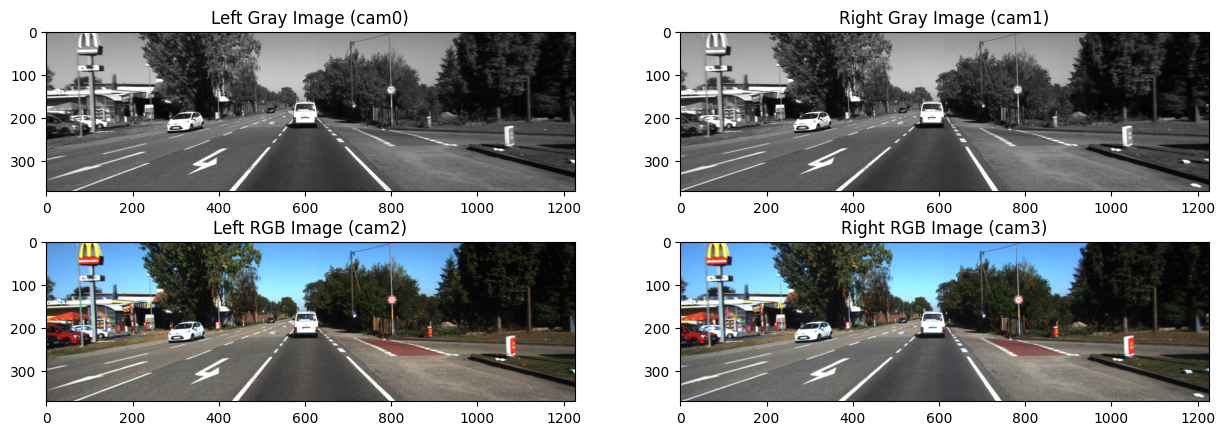

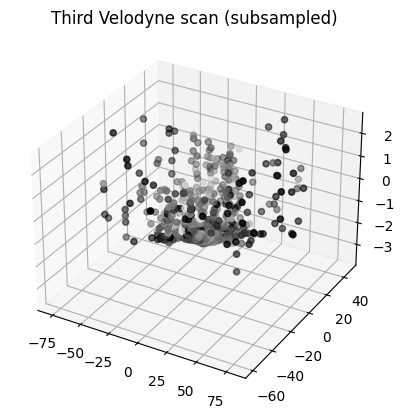

In [3]:
# Grab some data
second_pose = dataset.poses[1]
first_gray = next(iter(dataset.gray))
first_cam1 = next(iter(dataset.cam1))
first_rgb = dataset.get_rgb(0)
first_cam2 = dataset.get_cam2(0)
third_velo = dataset.get_velo(2)

# Display some of the data
np.set_printoptions(precision=4, suppress=True)
print('\nSequence: ' + str(dataset.sequence))
print('\nFrame range: ' + str(dataset.frames))

print('\nGray stereo pair baseline [m]: ' + str(dataset.calib.b_gray))
print('\nRGB stereo pair baseline [m]: ' + str(dataset.calib.b_rgb))

print('\nFirst timestamp: ' + str(dataset.timestamps[0]))
print('\nSecond ground truth pose:\n' + str(second_pose))

f, ax = plt.subplots(2, 2, figsize=(15, 5))
ax[0, 0].imshow(first_gray[0], cmap='gray')
ax[0, 0].set_title('Left Gray Image (cam0)')

ax[0, 1].imshow(first_cam1, cmap='gray')
ax[0, 1].set_title('Right Gray Image (cam1)')

ax[1, 0].imshow(first_cam2)
ax[1, 0].set_title('Left RGB Image (cam2)')

ax[1, 1].imshow(first_rgb[1])
ax[1, 1].set_title('Right RGB Image (cam3)')

f2 = plt.figure()
ax2 = f2.add_subplot(111, projection='3d')
# Plot every 100th point so things don't get too bogged down
velo_range = range(0, third_velo.shape[0], 100)
ax2.scatter(third_velo[velo_range, 0],
            third_velo[velo_range, 1],
            third_velo[velo_range, 2],
            c=third_velo[velo_range, 3],
            cmap='gray')
ax2.set_title('Third Velodyne scan (subsampled)')

plt.show()

In [4]:
frame_1 = np.array(dataset.get_rgb(0)[0])
frame_2 = np.array(dataset.get_rgb(1)[0])

In [5]:
frame_1.shape, frame_2.shape

((370, 1226, 3), (370, 1226, 3))

In [6]:
num_features = 2000

orb = cv2.ORB_create(nfeatures=num_features)

key_points_1, descriptors_1 = orb.detectAndCompute(frame_1, None)
key_points_2, descriptors_2 = orb.detectAndCompute(frame_2, None)


In [ ]:
bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = bf_matcher.match(descriptors_1, descriptors_2)

matches = sorted(matches, key=lambda x: x.distance)

In [39]:
img = cv2.drawMatches(frame_1, key_points_1, frame_2, key_points_2, matches[:50], None)

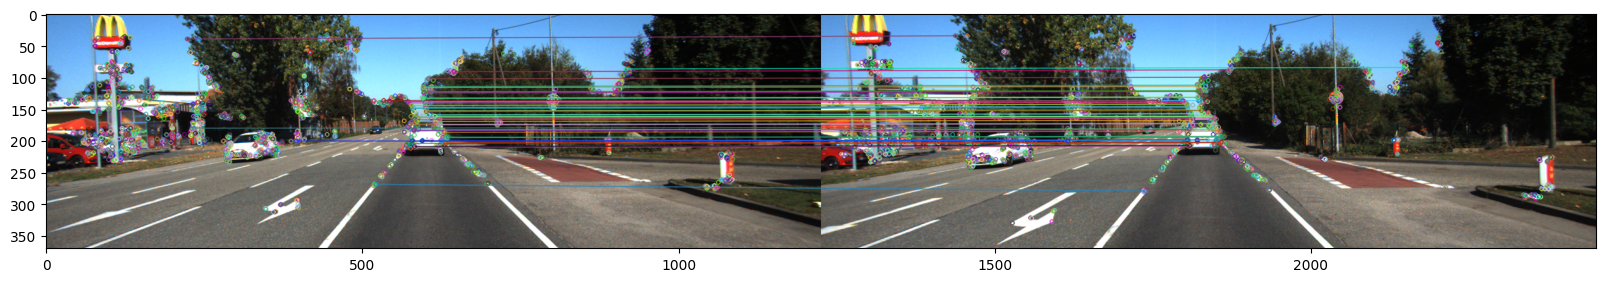

In [40]:
plt.figure(figsize=(20,16))
plt.imshow(img)
plt.show()

In [23]:
p1 = np.array([key_points_1[m.queryIdx].pt for m in matches]).astype(np.float32)
p2 = np.array([key_points_2[m.trainIdx].pt for m in matches]).astype(np.float32)

In [34]:
dataset.calib.K_cam3

array([[707.0912,   0.    , 601.8873],
       [  0.    , 707.0912, 183.1104],
       [  0.    ,   0.    ,   1.    ]])

In [36]:
K = dataset.calib.K_cam3

f = K[0,0]
cx = K[0, 2]
cy = K[1, 2]

In [37]:
e_matrix, mask = cv2.findEssentialMat(p1, p2, focal=f, pp=(cx, cy), method=cv2.RANSAC, prob=0.999, threshold=1)

p1 = p1[mask.ravel() == 1]
p2 = p2[mask.ravel() == 1]

_, R, t, mask = cv2.recoverPose(e_matrix, p1, p2, focal=f, pp=(cx, cy))

In [38]:
R = R.transpose()
t = -np.matmul(R, t)

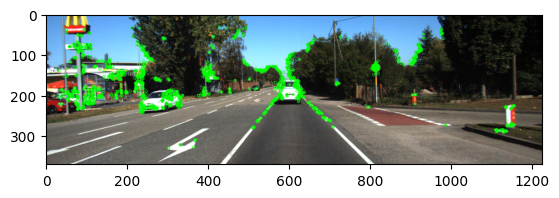

In [41]:
img_mov = cv2.drawKeypoints(frame_2, key_points_2, None, color=(0, 255,0,), flags=0)
plt.imshow(img_mov)
plt.show()

Now do it for all the sequence

In [43]:
len(dataset.poses)

271

In [44]:
np.eye(4)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [149]:
num_features = 6000
num_frames = len(dataset.poses)

dataset.calib.K_cam3
K = dataset.calib.K_cam3
f = K[0,0]
cx = K[0, 2]
cy = K[1, 2]


R_rolling = np.eye(3)
t_rolling = np.zeros(3).reshape(3, 1)


R_gt_rolling = np.eye(3)
t_gt_rolling = np.zeros(3).reshape(3, 1)

img_matches = []
img_moves = []
trajectory = []

frame_prev = np.array(dataset.get_rgb(0)[0])

len_traj = 1200
traj_map = np.zeros((len_traj, len_traj, 3), dtype=np.uint8)
traj_map_gt = np.zeros((len_traj, len_traj, 3), dtype=np.uint8)


for i in tqdm(range(1, num_frames)):

    orb = cv2.ORB_create(nfeatures=num_features)
    
    frame_now = np.array(dataset.get_rgb(i)[0])
    
    key_points_1, descriptors_1 = orb.detectAndCompute(frame_prev, None)
    key_points_2, descriptors_2 = orb.detectAndCompute(frame_now, None)


    bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    matches = bf_matcher.match(descriptors_1, descriptors_2)

    matches = sorted(matches, key=lambda x: x.distance)

    img = cv2.drawMatches(frame_1, key_points_1, frame_2, key_points_2, matches[:50], None)
    
    img_matches.append(img)

    p1 = np.array([key_points_1[m.queryIdx].pt for m in matches]).astype(np.float32)
    p2 = np.array([key_points_2[m.trainIdx].pt for m in matches]).astype(np.float32)


    e_matrix, mask = cv2.findEssentialMat(p1, p2, focal=f, pp=(cx, cy), method=cv2.RANSAC, prob=0.999, threshold=1)

    p1 = p1[mask.ravel() == 1]
    p2 = p2[mask.ravel() == 1]

    _, R, t, mask = cv2.recoverPose(e_matrix, p1, p2, focal=f, pp=(cx, cy))

    R = R.transpose()
    t = -np.matmul(R, t)
    
    t_rolling = t_rolling + np.matmul(R_rolling, t)
    R_rolling = np.matmul(R, R_rolling)
    
    t_gt = dataset.poses[i][:3,3].reshape(3, 1)
    R_gt = dataset.poses[i][:3,:3]
    
    t_gt_rolling = t_gt_rolling + np.matmul(R_gt_rolling, t_gt)
    R_gt_rolling = np.matmul(R_gt, R_gt_rolling)
    
    img_mov = cv2.drawKeypoints(frame_now, key_points_2, None, color=(0, 255,0,), flags=0)
    img_moves.append(img_mov)
    
    frame_prev = frame_now
    
    offset_draw = (int(len_traj / 2))

    cv2.circle(traj_map, (int(t_rolling[0])+offset_draw, int(t_rolling[2])+offset_draw), 1, (0,0,255), 2)
    cv2.circle(traj_map, (int(t_gt[0])+offset_draw, int(t_gt[2])+offset_draw), 1, (0,255,0), 2)
    
    trajectory.append(traj_map.copy())
    
#     plt.imshow(traj_map)
#     plt.show()
    

  0%|          | 0/1590 [00:00<?, ?it/s]

In [150]:
out_vis = []

for i in range(len(trajectory)):
    
    vis = np.zeros((trajectory[i].shape[0], img_moves[i].shape[1], 3)).astype(np.uint8)
    
    vis[315:315 + img_moves[i].shape[0], :, :] = img_moves[i]
    
    vis = np.concatenate([vis, trajectory[i]], axis=1)
    
    out_vis.append(vis)

In [151]:
imageio.mimsave('trajectory_vis_09_6000_pts.gif', out_vis)